In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import ERFutils
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import copy

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
def calc_ERF_sensitivity(ERF_ds,tas_CMIP,model_set,lam_dict,pct_sens,SSP=False):
    ERF_sens = copy.deepcopy(ERF_ds)

    for m in model_set:
        tas_CMIP_glob_m = tas_CMIP.sel(model=m).weighted(A).mean(dim=['lat','lon']).tas.values
        ERF_m = ERF_ds.sel(model=m).ERF.values
        lam = lam_dict[m]
        dN = ERF_m - lam*tas_CMIP_glob_m 
        
        ERF_sens_m = dN + (1 + pct_sens)*lam*tas_CMIP_glob_m
        ERF_sens.ERF.loc[dict(model=m)] = ERF_sens_m
        
    return ERF_sens

def add_hist_ssp(hist,ssp):
    # In the case of tas data
    if type(hist) == dict:
        ds = {}
        for m in hist.keys():
            ds[m] = xr.concat([hist[m],ssp[m]],dim = 'time')
    
    # In the case of ERF data
    else:
        ssp = ssp.assign_coords({'year':[int(i) for i in range(165,165+85)]})
        ds = xr.concat([hist,ssp],dim = 'year')
    return ds

Load 1pctCO2 as training data...
	Load 1pctCO2 run for convolution...
Convolving mean GF for Global Mean
Convolving mean GF Spatially
Convolving mean GF for Global Mean
Convolving mean GF Spatially
Convolving mean GF for Global Mean
Convolving mean GF Spatially
	Load ssp126 run for convolution...
Convolving mean GF for Global Mean
Convolving mean GF Spatially
Convolving mean GF for Global Mean
Convolving mean GF Spatially
Convolving mean GF for Global Mean
Convolving mean GF Spatially
	Load ssp245 run for convolution...
Convolving mean GF for Global Mean
Convolving mean GF Spatially
Convolving mean GF for Global Mean
Convolving mean GF Spatially
Convolving mean GF for Global Mean
Convolving mean GF Spatially
	Load ssp370 run for convolution...
Convolving mean GF for Global Mean
Convolving mean GF Spatially
Convolving mean GF for Global Mean
Convolving mean GF Spatially
Convolving mean GF for Global Mean
Convolving mean GF Spatially
	Load ssp585 run for convolution...
Convolving mean GF

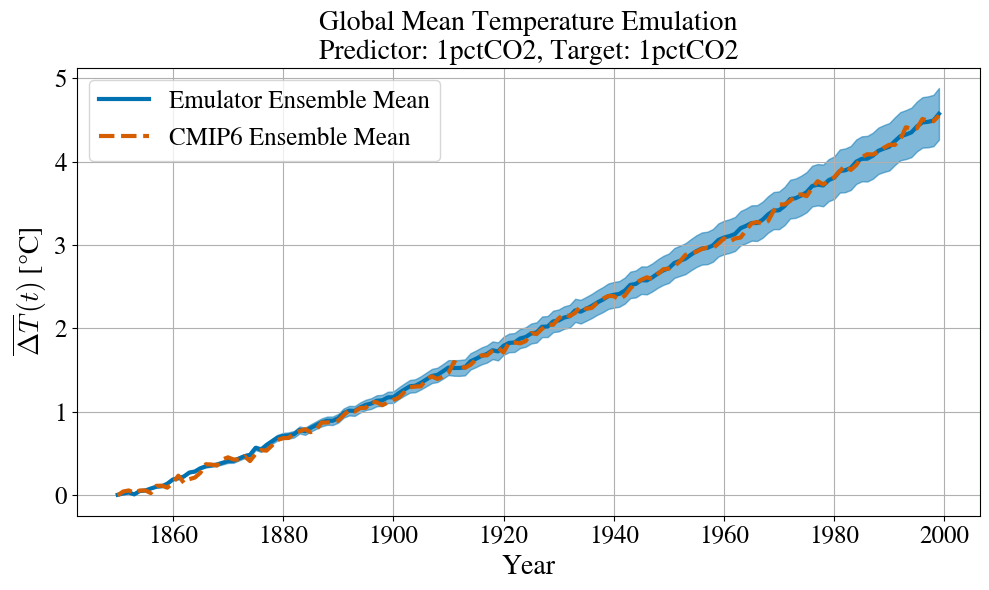

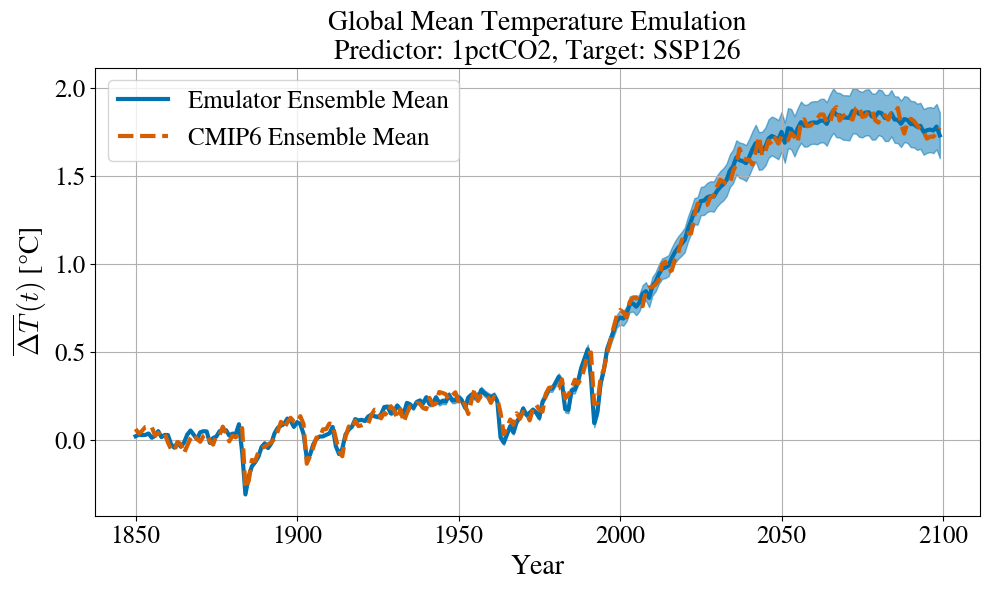

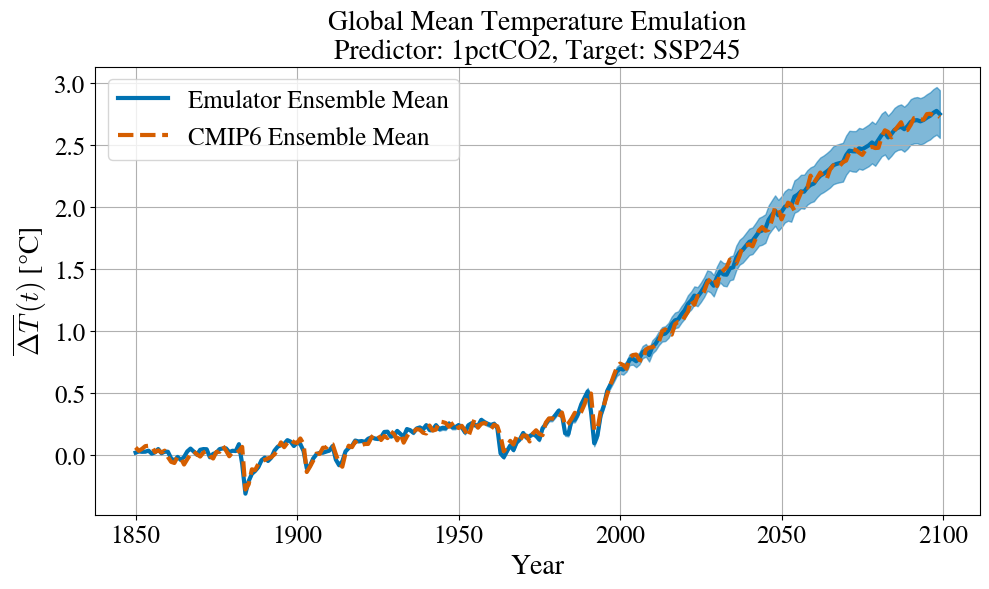

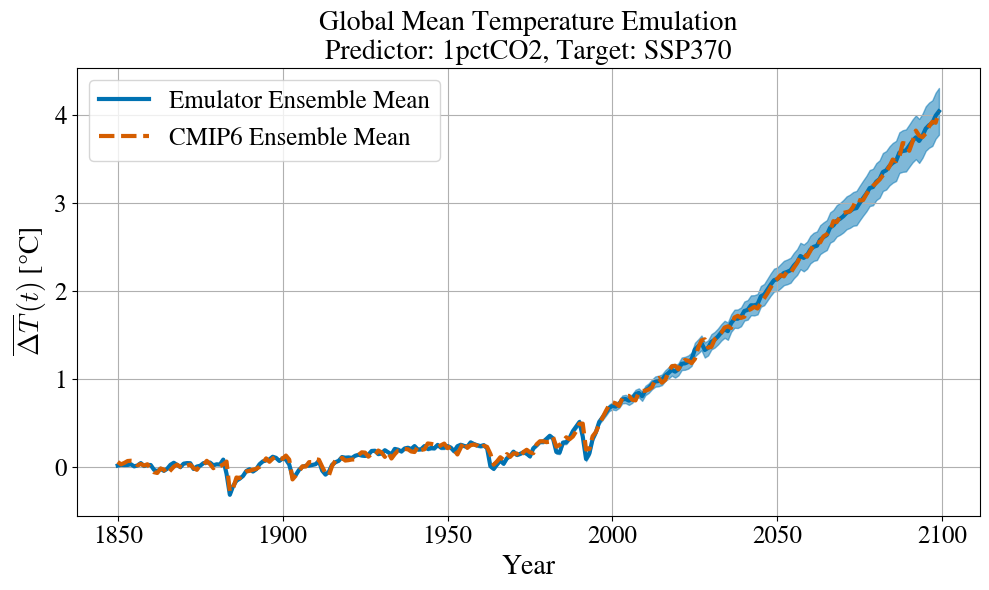

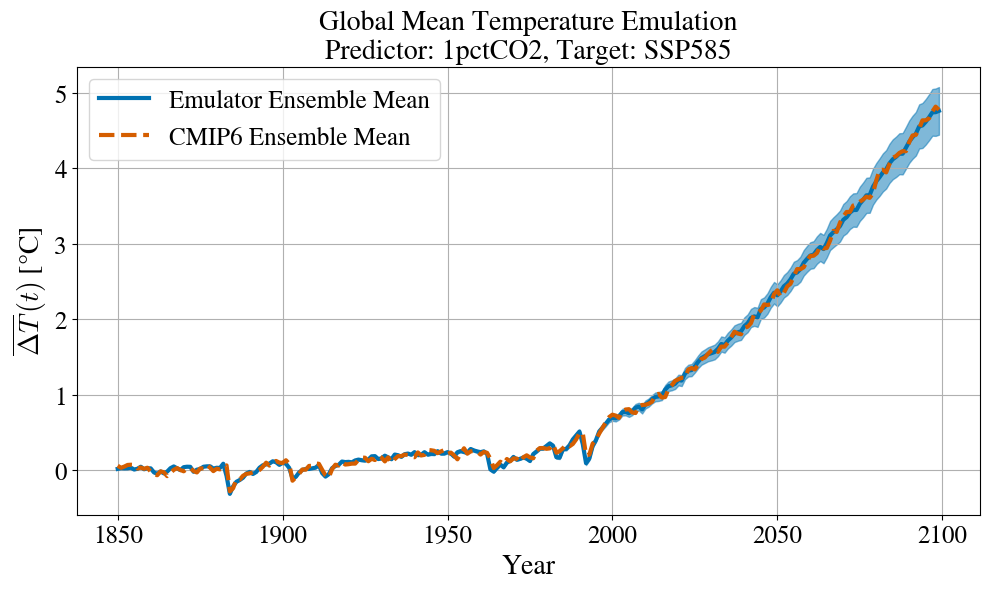

In [5]:
model_set = ERFutils.model_set
output_path = ERFutils.path_to_ERF_outputs

conv_all = ['1pctCO2','ssp126','ssp245','ssp370','ssp585']
train_id = '1pctCO2'

A = ERFutils.A
lam_dict = ERFutils.lam_dict
model_set = ERFutils.model_set

save_fig = False

print(f'Load {train_id} as training data...')

# Import Green's Functions
G_ds_path = f'{output_path}GFs/G_{train_id}_mean_ds.nc4'
G_ds = xr.open_dataset(G_ds_path)['G[tas]']

G_ds.name = 'G[tas]'
G_ds = G_ds.rename({'year':'s'})

RMSE_short, RMSE_long, RMSE_short_p10, RMSE_long_p10, RMSE_short_m10, RMSE_long_m10 = [], [], [], [], [], []
MAE_short, MAE_long, MAE_short_p10, MAE_long_p10, MAE_short_m10, MAE_long_m10 = [], [], [], [], [], []
bias_short, bias_long, bias_short_p10, bias_long_p10, bias_short_m10, bias_long_m10 = [], [], [], [], [], []
    
for conv_id in conv_all:
    print(f'\tLoad {conv_id} run for convolution...')

    # Import experimental ERF data
    ERF_path = f'{output_path}ERF/ERF_{conv_id}_all_ds.nc4'
    if 'ssp' in conv_id:
        ERF_path_hist = f'{output_path}ERF/ERF_historical_all_ds.nc4'
        ERF_ssp = xr.open_dataset(ERF_path)
        ERF_hist = xr.open_dataset(ERF_path_hist)

        ERF_ds = xr.concat([ERF_hist,ERF_ssp.assign_coords(year = range(165,250))],dim = 'year')

    else:
        ERF_ds = xr.open_dataset(ERF_path)

    # Import CMIP tas data
    tas_CMIP_path = f'{output_path}tas/tas_CMIP_{conv_id}_all_ds.nc4'
    tas_CMIP = xr.open_dataset(tas_CMIP_path) 

    if '1pctCO2' in conv_id:
        tas_CMIP = tas_CMIP.sel(s=slice(0,149))

    ERF_ds_min10 = calc_ERF_sensitivity(ERF_ds,tas_CMIP,model_set,lam_dict,-0.1)
    ERF_ds_plu10 = calc_ERF_sensitivity(ERF_ds,tas_CMIP,model_set,lam_dict,0.1)

    # Convolve
    conv_mean_ds = ERFutils.convolve_exp_meanGF(G_ds, ERF_ds, train_id, conv_mean = True)
    conv_ds = ERFutils.convolve_exp_meanGF(G_ds, ERF_ds, train_id, conv_mean = False)

    conv_mean_ds_min10 = ERFutils.convolve_exp_meanGF(G_ds, ERF_ds_min10, train_id, conv_mean = True)
    conv_ds_min10 = ERFutils.convolve_exp_meanGF(G_ds, ERF_ds_min10, train_id, conv_mean = False)

    conv_mean_ds_plu10 = ERFutils.convolve_exp_meanGF(G_ds, ERF_ds_plu10, train_id, conv_mean = True)
    conv_ds_plu10 = ERFutils.convolve_exp_meanGF(G_ds, ERF_ds_plu10, train_id, conv_mean = False) 

    if 'ssp' in conv_id: # SSP experiments
        start_yr1, plot_yr1, end_yr1 = 2040, 2050, 2060
        start_yr2, plot_yr2, end_yr2 = 2080, 2090, 2100
    elif 'hist' in conv_id: # Historical experiment
        start_yr, plot_yr, end_yr = 1850, 1975, 2015
    else: # 1pctCO2 experiment
        start_yr1, plot_yr1, end_yr1 = 1940, 1950, 1960
        start_yr2, plot_yr2, end_yr2 = 1980, 1990, 2000
        
    ERFutils.plot_conv_meanGF(train_id, conv_id, conv_mean_ds, tas_CMIP, sens = True,
                              conv_mean_ds_plu10 = conv_mean_ds_plu10, conv_mean_ds_min10 = conv_mean_ds_min10,
                              save_fig = save_fig)

    MSE1, RMSE1, MAE1, bias1 = ERFutils.calc_error_metrics(tas_CMIP, conv_ds, start_yr1, end_yr1, mean_GF = False)
    RMSE_short.append(round(RMSE1,4))
    MAE_short.append(round(float(MAE1),4))
    bias_short.append(round(float(bias1),4))

    MSE1_p10, RMSE1_p10, MAE1_p10, bias1_p10 = ERFutils.calc_error_metrics(tas_CMIP, conv_ds_plu10, start_yr1, end_yr1, mean_GF = False)
    RMSE_short_p10.append(round(RMSE1_p10,4))
    MAE_short_p10.append(round(float(MAE1_p10),4))
    bias_short_p10.append(round(float(bias1_p10),4))

    MSE1_m10, RMSE1_m10, MAE1_m10, bias1_m10 = ERFutils.calc_error_metrics(tas_CMIP, conv_ds_min10, start_yr1, end_yr1, mean_GF = False)
    RMSE_short_m10.append(round(RMSE1_m10,4))
    MAE_short_m10.append(round(float(MAE1_m10),4))
    bias_short_m10.append(round(float(bias1_m10),4))

    MSE2, RMSE2, MAE2, bias2 = ERFutils.calc_error_metrics(tas_CMIP, conv_ds, start_yr2, end_yr2, mean_GF = False)
    RMSE_long.append(round(RMSE2,4))
    MAE_long.append(round(float(MAE2),4))
    bias_long.append(round(float(bias2),4))

    MSE2_p10, RMSE2_p10, MAE2_p10, bias2_p10 = ERFutils.calc_error_metrics(tas_CMIP, conv_ds_plu10, start_yr2, end_yr2, mean_GF = False)
    RMSE_long_p10.append(round(RMSE2_p10,4))
    MAE_long_p10.append(round(float(MAE2_p10),4))
    bias_long_p10.append(round(float(bias2_p10),4))
        
    MSE2_m10, RMSE2_m10, MAE2_m10, bias2_m10 = ERFutils.calc_error_metrics(tas_CMIP, conv_ds_min10, start_yr2, end_yr2, mean_GF = False)
    RMSE_long_m10.append(round(RMSE2_m10,4))
    MAE_long_m10.append(round(float(MAE2_m10),4))
    bias_long_m10.append(round(float(bias2_m10),4))        

print('\nShort Stats...')
print(RMSE_short)
print(MAE_short)
print(bias_short)

print('\nShort Stats plus 10%...')
print(RMSE_short_p10)
print(MAE_short_p10)
print(bias_short_p10)

print('\nShort Stats minus 10%...')
print(RMSE_short_m10)
print(MAE_short_m10)
print(bias_short_m10)

print('\nLong Stats...')
print(RMSE_long)
print(MAE_long)
print(bias_long)

print('\nLong Stats plus 10%...')
print(RMSE_long_p10)
print(MAE_long_p10)
print(bias_long_p10)

print('\nLong Stats minus 10%...')
print(RMSE_long_m10)
print(MAE_long_m10)
print(bias_long_m10)